In [23]:
import cv2
import streamlit as st
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import numpy as np
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model
import pandas as pd
import time
import os
import statistics
import webbrowser
import os
from dotenv import load_dotenv
import requests
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.cluster import KMeans


In [24]:
# Load CSV file containing links for different emotions
df = pd.read_csv('data/kaggle_file.csv')


In [25]:
df.head()


,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [26]:
df.columns

Index(['valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date',
       'speechiness', 'tempo'],
      dtype='object')

In [27]:
features = df[['valence', 'energy', 'id']]

In [28]:
# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features[['valence', 'energy']])

c:\Users\danid\miniconda3\envs\conv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\danid\miniconda3\envs\conv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\danid\miniconda3\envs\conv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\danid\miniconda3\envs\conv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\dan

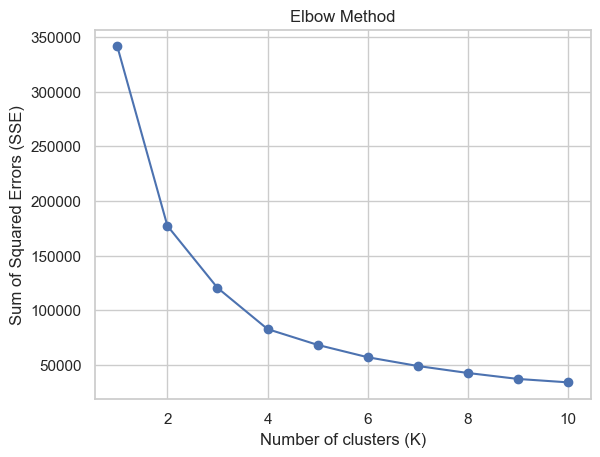

In [29]:
#Determine the optimal number of clusters (K) using the elbow method:

sse = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

# Plot the SSE vs K values
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method')
plt.show()


In [30]:


df['cluster'] = kmeans.labels_

In [31]:
# Assuming K = 4 based on the elbow method
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(scaled_features)


c:\Users\danid\miniconda3\envs\conv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

In [32]:
#kmeans.labels_ directly accesses the labels_ attribute of the fitted K-means model and assigns the labels to a new column named 'cluster' in the original DataFrame df.
df['cluster'] = kmeans.labels_


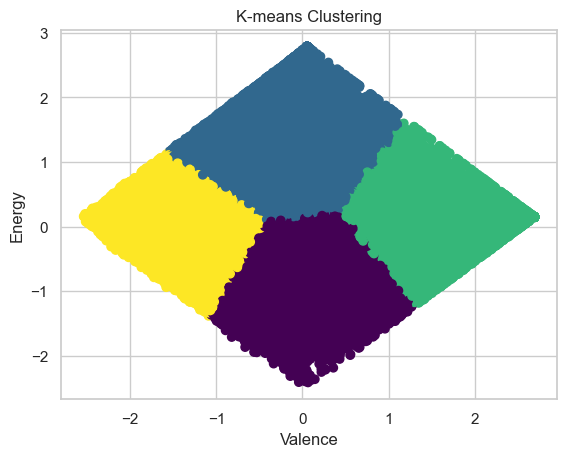

In [33]:
# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Scatter plot of the first two principal components colored by cluster label
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('Valence')
plt.ylabel('Energy')
plt.title('K-means Clustering')
plt.show()


In [34]:
# Calculate mean values of features for each cluster
cluster_summary = df.groupby('cluster')[['valence', 'energy']].mean()
print(cluster_summary)

          valence    energy
cluster                    
0        0.665325  0.325990
1        0.383620  0.741933
2        0.233710  0.213204
3        0.807275  0.714762


### Based on the mean values of the features, try to understand the characteristics of the songs in each cluster. For example, a cluster with high mean values for danceability, valence, and energy might represent "happy" songs.

### Cluster 0 - Angry:

Valence: 0.498 (neutral)
Energy: 0.649 (high)
Explanation: Cluster 0 has a high energy level, a fast tempo, and neutral valence, which suggests that the songs in this cluster could be classified as angry.

### Cluster 1 - Neutral:

Valence: 0.534 (neutral)
Energy: 0.321 (low)

Explanation: Cluster 1 has low energy, moderate tempo, and neutral valence, indicating that the songs in this cluster could be classified as Neutral.

### Cluster 2 - Sad:

Valence: 0.211 (low)
Energy: 0.230 (very low)

Explanation: Cluster 2 has the lowest values for danceability, valence, and energy, along with a slow tempo, which suggests that the songs in this cluster could be classified as sad.

### Cluster 3 - Happy:

Valence: 0.763 (high)
Energy: 0.681 (high)

Explanation: Cluster 3 has high values for danceability, valence, and energy, as well as a moderate tempo, indicating that the songs in this cluster could be classified as happy.

In [35]:
# Define the cluster-to-emotion mapping based on your analysis
cluster_to_emotion = {
    0: 'neutral',
    1: 'angry',
    2: 'sad',
    3: 'happy'
}

# Map the cluster labels to emotions
df['emotion'] = df['cluster'].map(cluster_to_emotion)


In [36]:
df

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,cluster,emotion
0,0.0594,1921,0.98200,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,...,0.6650,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,2,sad
1,0.9630,1921,0.73200,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,...,0.1600,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,0,neutral
2,0.0394,1921,0.96100,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,...,0.1010,-14.850,1,Gati Bali,5,1921,0.0339,110.339,2,sad
3,0.1650,1921,0.96700,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,...,0.3810,-9.316,1,Danny Boy,3,1921,0.0354,100.109,2,sad
4,0.2530,1921,0.95700,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,...,0.2290,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,2,sad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170648,0.6080,2020,0.08460,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",0.786,301714,0.808,0,0KkIkfsLEJbrcIhYsCL7L5,0.000289,...,0.0822,-3.702,1,China,72,2020-05-29,0.0881,105.029,3,happy
170649,0.7340,2020,0.20600,['Ashnikko'],0.717,150654,0.753,0,0OStKKAuXlxA0fMH54Qs6E,0.000000,...,0.1010,-6.020,1,Halloweenie III: Seven Days,68,2020-10-23,0.0605,137.936,3,happy
170650,0.6370,2020,0.10100,['MAMAMOO'],0.634,211280,0.858,0,4BZXVFYCb76Q0Klojq4piV,0.000009,...,0.2580,-2.226,0,AYA,76,2020-11-03,0.0809,91.688,3,happy
170651,0.1950,2020,0.00998,['Eminem'],0.671,337147,0.623,1,5SiZJoLXp3WOl3J4C8IK0d,0.000008,...,0.6430,-7.161,1,Darkness,70,2020-01-17,0.3080,75.055,1,angry


In [37]:
# Save the updated dataset to a new CSV file
df.to_csv('data/songs_with_emotions_valence-energy_2.csv', index=False) 

In [38]:
inertia = kmeans.inertia_
inertia

82723.92621732347

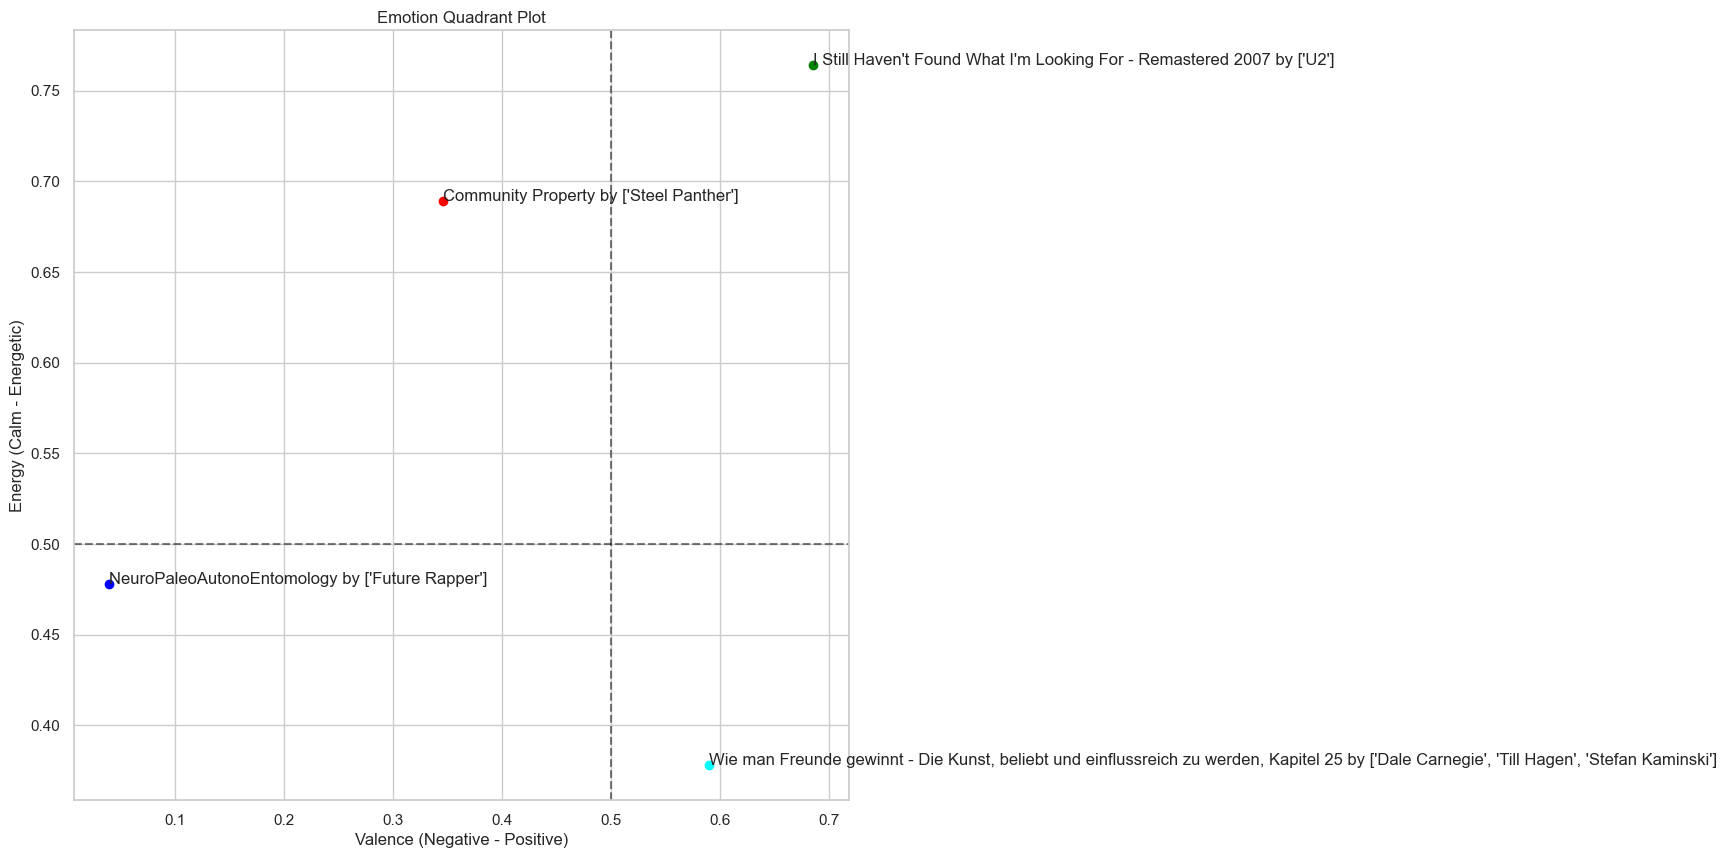

In [39]:
# Step 4: Create a quadrant graph
fig, ax = plt.subplots(figsize=(10, 10))

# Group the dataframe by emotion and take the row with the highest popularity score in each group
top_songs_df = df.groupby('emotion').apply(lambda x: x.sample(n=1))

# Create a scatter plot with different colors for each quadrant
colors = {'happy': 'green', 'neutral': 'cyan',
          'angry': 'red', 'sad': 'blue'}
for i, row in top_songs_df.iterrows():
    ax.scatter(row['valence'], row['energy'], color=colors[i[0]])
    ax.annotate(row['name'] + ' by ' + row['artists'], (row['valence'], row['energy']))
    
# Add labels to the plot
ax.set_xlabel('Valence (Negative - Positive)')
ax.set_ylabel('Energy (Calm - Energetic)')
ax.set_title('Emotion Quadrant Plot')

# Add vertical and horizontal lines at the middle of the graph
ax.axhline(y=0.5, color='black', alpha=0.5, linestyle='--')
ax.axvline(x=0.5, color='black', alpha=0.5, linestyle='--')

# Show the plot
plt.show()


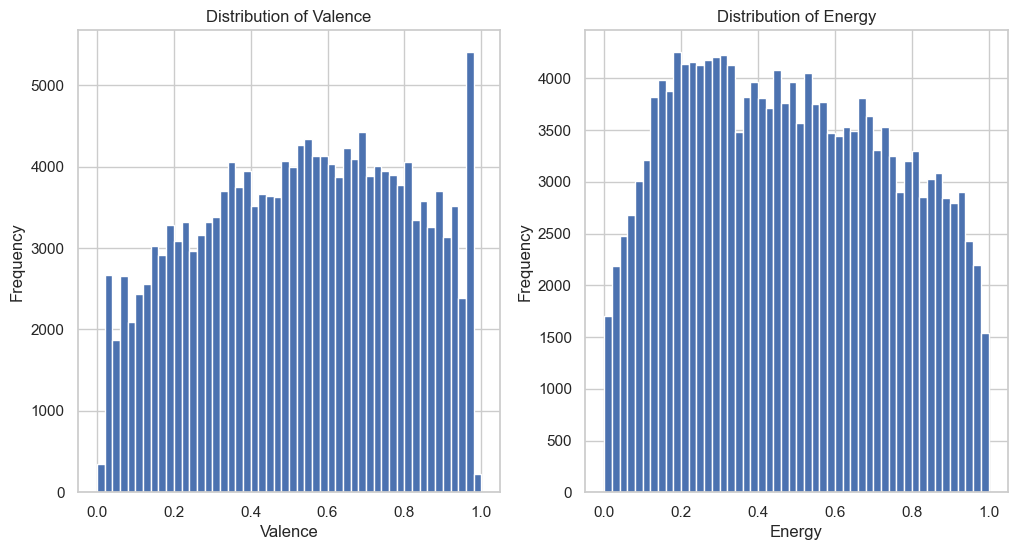

In [40]:
# Create the plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the histogram of valence with hist() function
axs[0].hist(df['valence'], edgecolor="white", bins=50)

# Label axes and set title
axs[0].set_title("Distribution of Valence")
axs[0].set_xlabel("Valence")
axs[0].set_ylabel("Frequency")

# Plot the histogram of energy with hist() function
axs[1].hist(df['energy'], edgecolor="white", bins=50)

# Label axes and set title
axs[1].set_title("Distribution of Energy")
axs[1].set_xlabel("Energy")
axs[1].set_ylabel("Frequency")

# Display the plot
plt.show()


In [41]:
# Convert the 'emotion' column to a categorical data type
df_2 = df
df_2['emotion'] = df_2['emotion'].astype('category')

# Create a one-hot encoding of the 'emotion' column
one_hot_df = pd.get_dummies(df_2['emotion'], prefix='emotion')

# Add the one-hot encoded columns to the original DataFrame
df_2 = pd.concat([df, one_hot_df], axis=1)


C:\Users\danid\AppData\Local\Temp\ipykernel_9552\378909136.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_2.corr()


<Axes: >

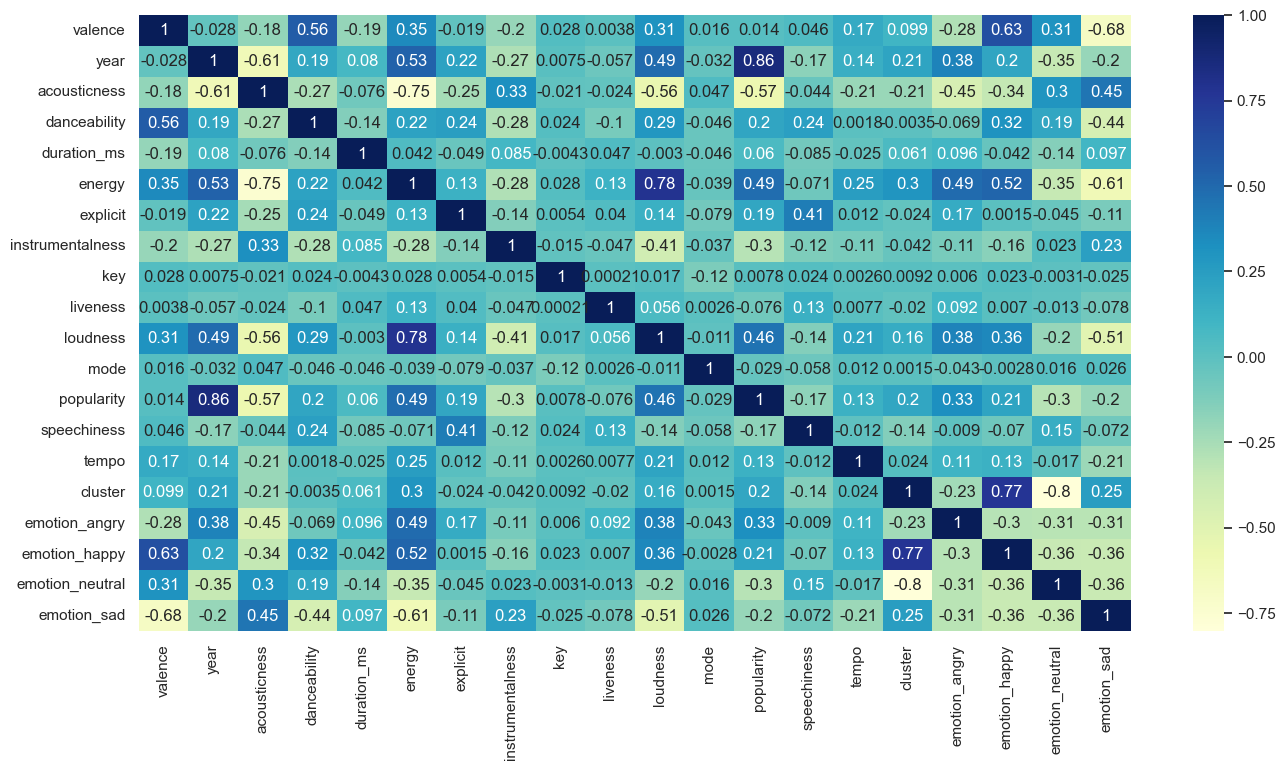

In [42]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = df_2.corr()
sns.heatmap(corr,annot=True, cmap="YlGnBu")


C:\Users\danid\AppData\Local\Temp\ipykernel_9552\233804269.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_2.corr()


<Axes: >

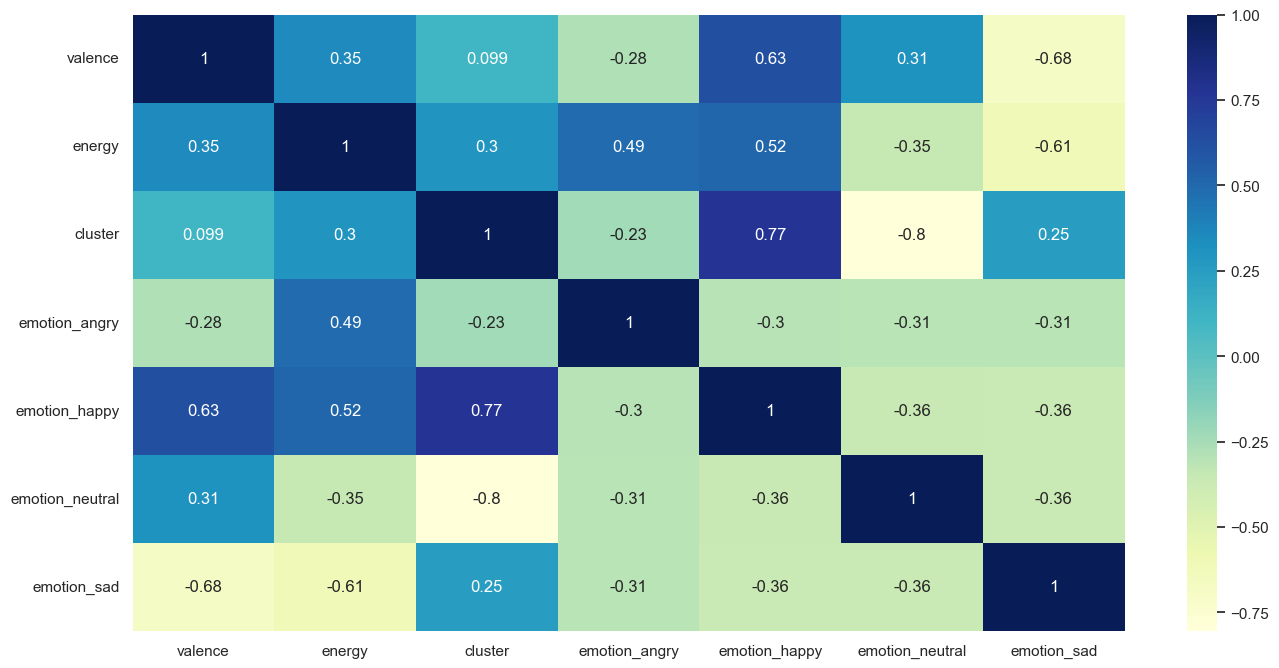

In [43]:
df_2.drop(['year', 'acousticness', 'danceability',
       'duration_ms', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'popularity', 'release_date',
       'speechiness', 'tempo', 'emotion'], axis = 1, inplace = True)
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = df_2.corr()
sns.heatmap(corr,annot=True, cmap="YlGnBu")

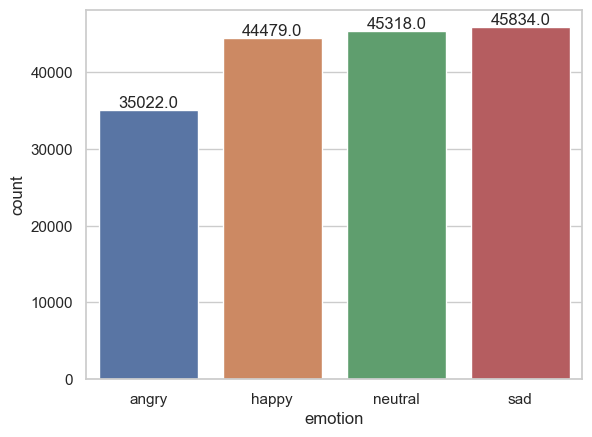

In [44]:
sns.countplot(x=df['emotion'])
ax = plt.gca()
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')